In [1]:
import torch
import torchvision.datasets as datasets
from torchmetrics.image.fid import FrechetInceptionDistance
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

# Set seed here
import random
import numpy as np
seed = 123459
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

In [2]:
def compute_FID(image_r, image_f):
    _ = torch.manual_seed(1982)
    fid = FrechetInceptionDistance(feature=64)
    fid.update(image_r, real=True)
    fid.update(image_f, real=False)
    FID = fid.compute()
    return FID


def encode_image(img):
    transform = transforms.Compose([transforms.PILToTensor()])
    return transform(img)

def load_data(train_loader, test_loader, sample, dims):
    _, (train, targets) = next(enumerate(train_loader))
    _, (test, targets) = next(enumerate(test_loader))
    train_tensor = train.expand([sample, 3, dims[0], dims[1]])
    test_tensor = test.expand([sample, 3, dims[0], dims[1]])
    return train_tensor, test_tensor

## Data Sets

In [25]:
# MNIST
MNIST_train_loader = DataLoader(datasets.MNIST('./data', train=True, download=True,
                             transform=transforms.Compose([
                               transforms.PILToTensor()])), batch_size=1000, shuffle=True);

MNIST_test_loader =  DataLoader(datasets.MNIST('./data', train=False, download=True,
                             transform=transforms.Compose([
                               transforms.PILToTensor()])), batch_size=1000, shuffle=True);
MNIST_train, MNIST_test = load_data(MNIST_train_loader, MNIST_test_loader, 1000, (28, 28))

# Base FID
compute_FID(MNIST_train, MNIST_test)

tensor(0.0006)

In [26]:
# CIFAR 100
CIFAR_train_loader = DataLoader(datasets.CIFAR100('./data', train=True, download=True,
                             transform=transforms.Compose([
                               transforms.PILToTensor()])), batch_size=1000, shuffle=True);

CIFAR_test_loader =  DataLoader(datasets.CIFAR100('./data', train=False, download=True,
                             transform=transforms.Compose([
                               transforms.PILToTensor()])), batch_size=1000, shuffle=True);
CIFAR_train, CIFAR_test = load_data(CIFAR_train_loader, CIFAR_test_loader, 1000, (32, 32))

# Base FID
compute_FID(CIFAR_train, CIFAR_test)

Files already downloaded and verified
Files already downloaded and verified


tensor(0.0150)

In [27]:
# CelebA
CelebA_train_loader = DataLoader(datasets.CelebA('./data', split="train", download=True,
                             transform=transforms.Compose([
                               transforms.PILToTensor()])), batch_size=1000, shuffle=True);

CelebA_test_loader =  DataLoader(datasets.CelebA('./data', split="test", download=True,
                             transform=transforms.Compose([
                               transforms.PILToTensor()])), batch_size=1000, shuffle=True);
CelebA_train, CelebA_test = load_data(CelebA_train_loader, CelebA_test_loader, 1000, (218, 178))

# Base FID
compute_FID(CelebA_train, CelebA_test)

Files already downloaded and verified
Files already downloaded and verified


tensor(0.0281)

## Gamma Correction

In [6]:
def compute_gamma_FID(gamma, dataset_train, dataset_test):
    gamma_test = transforms.functional.adjust_gamma(dataset_test, gamma)
    return compute_FID(dataset_train, gamma_test).item()

In [7]:
compute_gamma_FID(2,CelebA_train, CelebA_test)

2.9917736053466797

[0.14362123608589172,
 0.05152800306677818,
 0.014329930767416954,
 0.0019983856473118067,
 0.0016129440627992153,
 0.0074999770149588585,
 0.016620147973299026,
 0.027606500312685966,
 0.03911667317152023,
 0.051562681794166565,
 0.06323660165071487,
 0.07476598024368286,
 0.08641263842582703,
 0.09713439643383026]

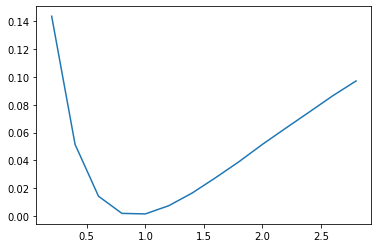

In [8]:
gamma_array = np.arange(0.2, 3.0, 0.2)
gamma_FID = [compute_gamma_FID(g, MNIST_train, MNIST_test) for g in gamma_array]
plt.plot(gamma_array, gamma_FID)

## Image Rotation

In [9]:
def compute_rotate_FID(angle, dataset_train, dataset_test):
    rotated_test = transforms.functional.rotate(dataset_test, angle)
    return compute_FID(dataset_train, rotated_test).item()

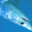

In [10]:
rotated_test = transforms.functional.rotate(CIFAR_test, 90)
this = transforms.functional.to_pil_image(rotated_test[0])
this
# rotated_test = transforms.functional.rotate(dataset_test, angle)

In [11]:
compute_rotate_FID(90, CIFAR_train, CIFAR_test)

0.027028370648622513

In [20]:
compute_rotate_FID(180, CelebA_train, CelebA_test)

0.03830832988023758

In [21]:
compute_rotate_FID(270, MNIST_train, MNIST_test)

0.01797214336693287

## Image Saturation

In [12]:
def compute_saturation_FID(factor, dataset_train, dataset_test):
    saturated_test = transforms.functional.adjust_saturation(dataset_test, factor)
    return compute_FID(dataset_train, saturated_test).item()

In [13]:
compute_saturation_FID(0.4, CIFAR_train, CIFAR_test)

0.7692213654518127

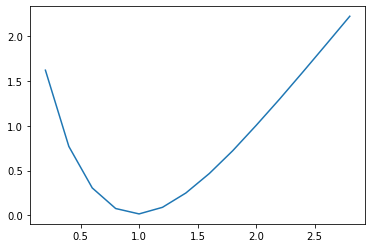

In [14]:
level_array = np.arange(0.2, 3.0, 0.2)
sat_FID = [compute_saturation_FID(l, CIFAR_train, CIFAR_test) for l in level_array]
plt.plot(level_array, sat_FID)
plt.show()

## Sectional Rotations

In [30]:
def remove_chunk(dataset_train, dataset_test):
    x1, y1, x2, y2 = 10, 10, 20, 20
    dataset_test_rotated = torch.clone(dataset_test)
    dataset_test_rotated[:, :, y1:y2, x1:x2] = transforms.functional.rotate(dataset_test_rotated[:, :, y1:y2, x1:x2], 180)
    display = transforms.functional.to_pil_image(dataset_test_rotated[0])
    return compute_FID(dataset_train, dataset_test_rotated).item()

In [31]:
print(remove_chunk(MNIST_train, MNIST_train))
print(remove_chunk(CIFAR_train, CIFAR_test))
print(remove_chunk(CelebA_train, CelebA_test))

0.008750141598284245
0.018010301515460014
0.02773781679570675


In [32]:
# As long as your distribution is close to the real pictures u get good score?
# What is inception looking at? (worth looking into with perception map?) How is it not picking up the unatural edge?
# Is the Inception doing its job but when FID does the aggregating the distribution all this info is lost?

## Compression (JPEG and PNG)

## Resizing

In [ ]:
# In general we do see worse off performance across all these image adjustments, hypothetically is it helpful/conclusive to say that
# "since there is no change to the perceived realism, we must conclude that any FID score increase is not justified", 
# is this in a way redundant statement almost, surely everyone knows this right?

## Removing Noise From Test Images? (or add unseen ones too)

In [ ]:
# How do we make sure the noise we add/remove is significant? (blurring, SP noise, sharpening, edge presvering)